In [1]:
import tensorflow as tf

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print("GPU terdeteksi:")
    print(gpus)
else:
    print("GPU tidak terdeteksi")

GPU terdeteksi:
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
import os
from enum import Enum
import cv2
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import tensorflow as tf
from keras_unet.utils import plot_segm_history
import keras.backend as K
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, classification_report
from keras_unet.utils import plot_segm_history

-----------------------------------------
keras-unet init: TF version is >= 2.0.0 - using `tf.keras` instead of `Keras`
-----------------------------------------


In [3]:
# Fungsi untuk menampilkan gambar
def display_images(instances, rows=2, titles=None, figsize=(10, 5)):
    n = len(instances)
    cols = n // rows if (n / rows) % rows == 0 else (n // rows) + 1

    fig = plt.figure(figsize=figsize)

    for j, image in enumerate(instances):
        plt.subplot(rows, cols, j + 1)
        plt.title('') if titles is None else plt.title(titles[j])
        plt.axis("off")
        plt.imshow(image)

    plt.show()


In [4]:

def calculate_metrics_per_class(y_true, y_pred, class_names):
    """
    Calculate detailed metrics for each class
    """
    # Get confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Initialize dictionaries to store metrics
    sensitivity = {}
    specificity = {}
    accuracy = {}
    iou = {}
    f1 = {}
    dice = {}
    
    n_classes = len(class_names)
    
    # Calculate metrics for each class
    for idx, class_name in enumerate(class_names):
        # True Positive (TP): correctly identified
        TP = cm[idx, idx]
        # False Negative (FN): incorrectly identified as negative
        FN = np.sum(cm[idx, :]) - TP
        # False Positive (FP): incorrectly identified as positive
        FP = np.sum(cm[:, idx]) - TP
        # True Negative (TN): correctly identified as negative
        TN = np.sum(cm) - TP - FP - FN
        
        # Calculate metrics
        sensitivity[class_name] = TP / (TP + FN) if (TP + FN) > 0 else 0
        specificity[class_name] = TN / (TN + FP) if (TN + FP) > 0 else 0
        accuracy[class_name] = (TP + TN) / (TP + TN + FP + FN)
        iou[class_name] = TP / (TP + FP + FN) if (TP + FP + FN) > 0 else 0
        f1[class_name] = 2 * TP / (2 * TP + FP + FN) if (2 * TP + FP + FN) > 0 else 0
        dice[class_name] = 2 * TP / (2 * TP + FP + FN) if (2 * TP + FP + FN) > 0 else 0
    
    # Calculate averages
    metrics = {
        'Sensitivity': sensitivity,
        'Specificity': specificity,
        'Accuracy': accuracy,
        'IoU': iou,
        'F1-Score': f1,
        'Dice Coefficient': dice
    }
    
    # Add average to each metric
    for metric_name, metric_dict in metrics.items():
        metric_dict['Average'] = np.mean(list(metric_dict.values()))
    
    return metrics, cm

In [5]:
# Fungsi untuk one-hot encode masks
def one_hot_encode_masks(masks, num_classes):
    integer_encoded_labels = []
    for mask in tqdm(masks):
        _img_height, _img_width, _img_channels = mask.shape
        encoded_image = np.zeros((_img_height, _img_width, 1)).astype(int)
        for j, cls in enumerate(MaskColorMap):
            encoded_image[np.all(mask == cls.value, axis=-1)] = j
        integer_encoded_labels.append(encoded_image)
    return to_categorical(y=integer_encoded_labels, num_classes=num_classes)

In [6]:

class MaskColorMap(Enum):
    black = (0, 0, 0)
    red = (255, 0, 0)
    blue = (0, 0, 255)



In [7]:
# number of classes in segmentation dataset
n_classes = 3


In [8]:
# Fungsi untuk encode mask RGB
def rgb_encode_mask(mask):
    rgb_encode_image = np.zeros((mask.shape[0], mask.shape[1], 3))
    for j, cls in enumerate(MaskColorMap):
        rgb_encode_image[(mask == j)] = np.array(cls.value) / 255.
    return rgb_encode_image

In [9]:
import glob
import cv2 as cv

# Mendapatkan daftar file citra dalam direktori dan mengurutkannya
X = sorted(glob.glob('D:/Gio&Maul/maul/LES-AV/images_clahe/*.png'))
#D:/1_dina/BINER/PROCESSED
Y = sorted(glob.glob('D:/Gio&Maul/maul/LES-AV/arteries-and-veins_all/*.png'))

In [10]:

x_train= []

for i in range(len(X)):
    x = cv.imread(X[i])
    x = cv2.cvtColor(x,cv2.COLOR_BGR2RGB)
    x = cv2.resize(x,(512,512))
    x = x/255
    x_train.append(x)

X= np.array(x_train)
len(X)


132

In [11]:
# Prepare the Labels
y_train = []
for i in range(len(Y)):
    y = cv.imread(Y[i])
    y = cv2.cvtColor(y, cv2.COLOR_BGR2RGB)
    y = cv2.resize(y, (512, 512))
    y_train.append(y)

Y = np.array(y_train)
len(Y)

132

In [12]:
m, img_height, img_width, img_channels = X.shape
X.shape


(132, 512, 512, 3)

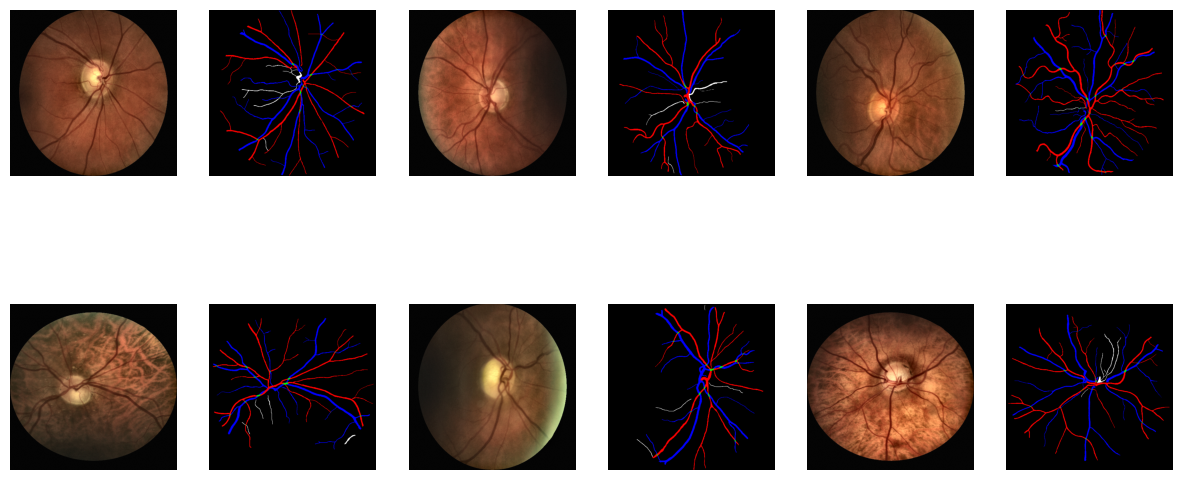

In [13]:
import matplotlib.pyplot as plt

# Set the number of images to display
display_count = 6

# Generate random indices
random_index = [np.random.randint(0, m) for _ in range(display_count)]

# Get the sample images
sample_images = [x for z in zip(list(X[random_index]), list(Y[random_index])) for x in z]

# Set the number of rows and columns for display
rows = 2
columns = display_count if display_count % 2 == 0 else display_count + 1

# Create a subplot and display images in a larger size
plt.figure(figsize=(15, 7))  # Adjust the figsize to your preferred size
for i, image in enumerate(sample_images):
    plt.subplot(rows, columns, i + 1)
    plt.imshow(image)
    plt.axis('off')

plt.show()


In [14]:
# convert RGB values to integer encoded labels for categorical_crossentropy
Y = one_hot_encode_masks(Y, num_classes=n_classes)

# split dataset into training and test groups
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)


100%|██████████| 132/132 [00:02<00:00, 54.16it/s]


In [15]:
Y.shape

(132, 512, 512, 3)

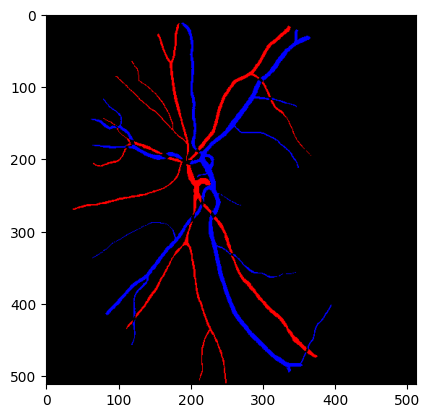

In [16]:
# Warna untuk setiap kelas (merah, hijau, biru, putih, hitam)
colors = [(0, 0, 0), (255, 0, 0), (0, 0, 255)]

# Buat gambar RGB kosong
mask_rgb = np.zeros((512, 512, 3), dtype=np.uint8)

# Iterasi setiap kelas dan tambahkan warna ke gambar RGB
for i, color in enumerate(colors):
    mask_rgb[Y[40][:, :, i] == 1] = color

# Tampilkan mask dalam format RGB
plt.imshow(mask_rgb)
plt.show()


In [17]:
print("X_train shape =",X_train.shape)

X_train shape = (105, 512, 512, 3)


In [18]:
# Fungsi untuk membagi citra menjadi patch
def create_patches(img, patch_size):
    patches = []
    h, w = img.shape[0], img.shape[1]
    for i in range(0, h, patch_size):
        for j in range(0, w, patch_size):
            patch = img[i:i+patch_size, j:j+patch_size]
            if patch.shape[0] == patch_size and patch.shape[1] == patch_size:
                patches.append(patch)
    return np.array(patches)

In [19]:
def recombine_patches(patches, original_size, patch_size):
    reconstructed_image = np.zeros(original_size)
    num_patches_per_row = original_size[0] // patch_size

    for i in range(num_patches_per_row):
        for j in range(num_patches_per_row):
            patch = patches[i * num_patches_per_row + j]
            reconstructed_image[i*patch_size:(i+1)*patch_size, j*patch_size:(j+1)*patch_size] = patch
    
    return reconstructed_image

In [20]:
# Membuat patch dari citra dan mask
patch_size = 256

In [21]:
# Membagi citra dan mask menjadi patch
X_patches = []
Y_patches = []

for img, mask in zip(X_train, Y_train):
    X_patches.extend(create_patches(img, patch_size))
    Y_patches.extend(create_patches(mask, patch_size))

X_patches = np.array(X_patches)
Y_patches = np.array(Y_patches)


Total patches pada X_train: 420
Total patches pada Y_train: 420


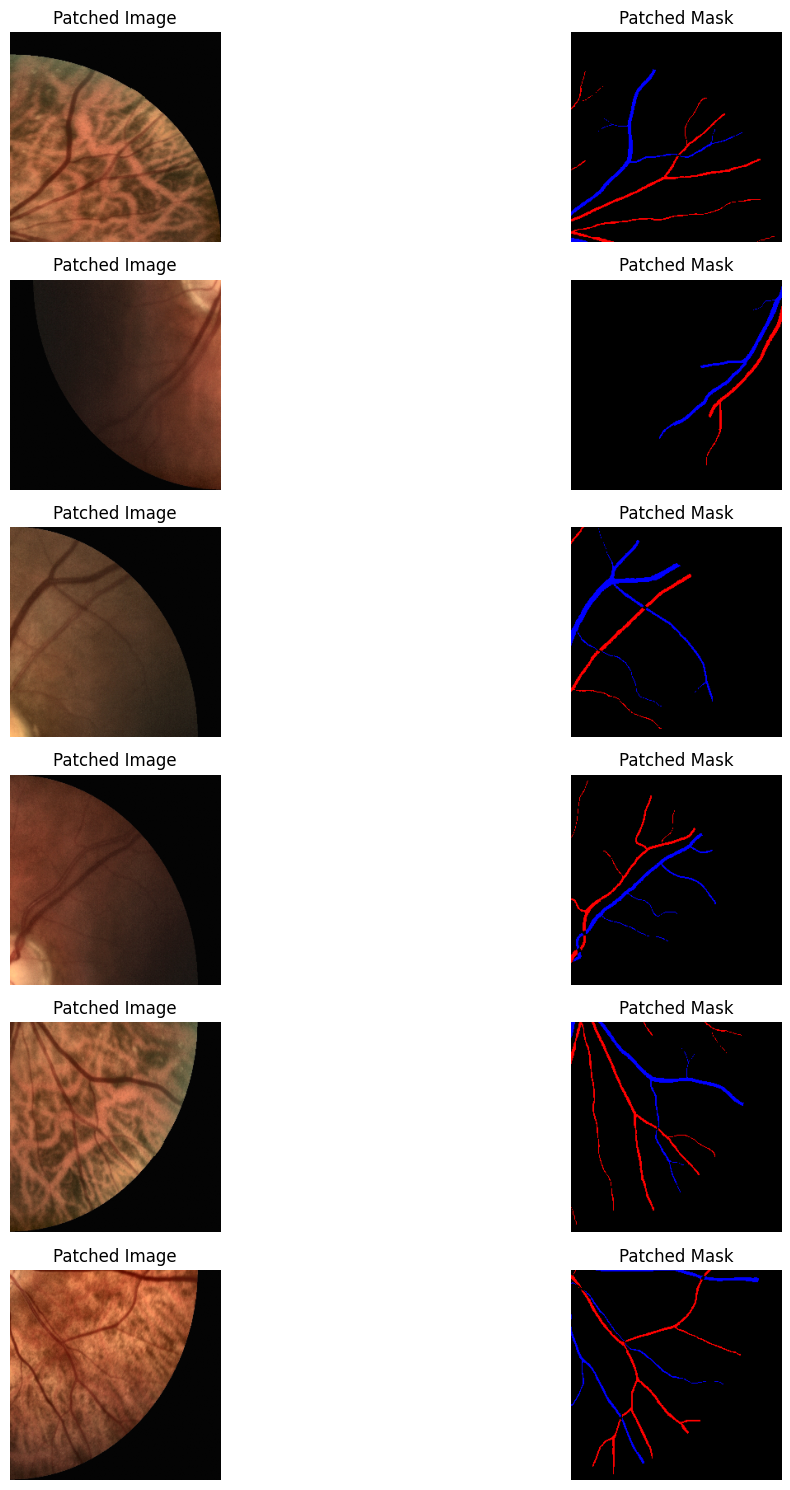

In [22]:
# Function to apply color mapping to the mask
def apply_color_map(mask, color_map):
    color_mask = np.zeros((*mask.shape[:2], 3), dtype=np.uint8)
    for i, color in enumerate(color_map):
        color_mask[mask == i] = np.array(color.value)
    return color_mask

# Tampilkan jumlah data setelah dipatching
total_patches_X = len(X_patches)
total_patches_Y = len(Y_patches)
print(f"Total patches pada X_train: {total_patches_X}")
print(f"Total patches pada Y_train: {total_patches_Y}")


# Tampilkan beberapa contoh gambar hasil patching dari X_train dan Y_train
num_examples = 6
plt.figure(figsize=(15, 15))

for i in range(num_examples):
    # Ambil contoh gambar dari X_patches secara acak
    rand_idx = np.random.randint(len(X_patches))
    patch_img = X_patches[rand_idx]
    patch_mask = Y_patches[rand_idx]
    
    # Tampilkan gambar hasil patching
    plt.subplot(num_examples, 2, 2*i + 1)
    plt.imshow(patch_img)
    plt.title('Patched Image')
    plt.axis('off')
    
    # Gabungkan semua channel mask menjadi satu
    combined_mask = np.argmax(patch_mask, axis=-1)
    colored_mask = apply_color_map(combined_mask, list(MaskColorMap))

    plt.subplot(num_examples, 2, 2*i + 2)
    plt.imshow(colored_mask)
    plt.title('Patched Mask')
    plt.axis('off')

plt.tight_layout()
plt.show()

In [23]:
 from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.initializers import he_normal
import tensorflow.keras.backend as K
import tensorflow as tf

# Convolution block
def convolution_block(block_input, num_filters, kernel_size=3, dilation_rate=1, activation='relu'):
    x = Conv2D(
        num_filters,
        kernel_size=kernel_size,
        padding="same",
        kernel_initializer=he_normal(),
        dilation_rate=dilation_rate
    )(block_input)
    x = BatchNormalization()(x)
    x = Activation(activation)(x)
    return x

# ASPP Block
def aspp_block(aspp_input, filters):
    dims = aspp_input.shape
    x = AveragePooling2D(pool_size=(dims[-3], dims[-2]))(aspp_input)
    x = convolution_block(x, filters, kernel_size=1)
    x = UpSampling2D(size=(dims[-3] // x.shape[1], dims[-2] // x.shape[2]), interpolation="bilinear")(x)

    out_1 = convolution_block(aspp_input, filters, kernel_size=1)
    out_6 = convolution_block(aspp_input, filters, kernel_size=3, dilation_rate=6)
    out_12 = convolution_block(aspp_input, filters, kernel_size=3, dilation_rate=12)
    out_18 = convolution_block(aspp_input, filters, kernel_size=3, dilation_rate=18)

    x = Concatenate(axis=-1)([x, out_1, out_6, out_12, out_18])
    x = convolution_block(x, filters, kernel_size=1)
    return x

# Squeeze-and-Excitation block
def se_block(se_input, reduction=16):
    filters = se_input.shape[-1]
    se = GlobalAveragePooling2D()(se_input)
    se = Dense(filters // reduction, activation='relu')(se)
    se = Dense(filters, activation='sigmoid')(se)
    se = Reshape((1, 1, filters))(se)
    x = Multiply()([se_input, se])
    return x

# Attention Gate function
def attention_gate(g, s, num_filters):
    Wg = Conv2D(num_filters, 1, padding="same")(g)
    Wg = BatchNormalization()(Wg)

    Ws = Conv2D(num_filters, 1, padding="same")(s)
    Ws = BatchNormalization()(Ws)

    out = Activation("relu")(Wg + Ws)
    out = Conv2D(num_filters, 1, padding="same")(out)
    out = Activation("sigmoid")(out)

    return out * s

# SEnet Decoder block with Attention Gate
def senet_decoder_block(layer_input, skip_connection, num_filters):
    x = UpSampling2D(size=(2, 2), interpolation="nearest")(layer_input)
    
    # Apply Attention Gate to the skip connection
    attention = attention_gate(x, skip_connection, num_filters)
    
    # Use the attention-weighted skip connection
    x = Concatenate(axis=-1)([x, attention])
    x = convolution_block(x, num_filters)
    x = se_block(x)  # Apply SE block
    x = convolution_block(x, num_filters)
    return x

# ASPP-U-Net with SEnet Decoder and Attention Gates
def aspp_unet_senet(height, width, n_channels, filters=16):
    inputs = Input((height, width, n_channels))

    # U-Net Encoder
    conv1 = convolution_block(inputs, filters)
    conv1 = convolution_block(conv1, filters)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = convolution_block(pool1, filters * 2)
    conv2 = convolution_block(conv2, filters * 2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = convolution_block(pool2, filters * 4)
    conv3 = convolution_block(conv3, filters * 4)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = convolution_block(pool3, filters * 8)
    conv4 = convolution_block(conv4, filters * 8)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    # ASPP Bottleneck
    bottleneck = aspp_block(pool4, filters * 16)

    # SEnet Decoder (upsampling + skip connections with Attention Gates)
    up6 = senet_decoder_block(bottleneck, conv4, filters * 8)
    up7 = senet_decoder_block(up6, conv3, filters * 4)
    up8 = senet_decoder_block(up7, conv2, filters * 2)
    up9 = senet_decoder_block(up8, conv1, filters)

    # Output
    outputs = Conv2D(3, (1, 1), activation='softmax')(up9)

    model = Model(inputs, outputs)
    return model

In [24]:
img_shape = (patch_size, patch_size, img_channels)
img_shape

(256, 256, 3)

In [25]:
from tensorflow.keras import backend as K
import tensorflow as tf

# jaccard similarity: the size of the intersection divided by the size of the union of two sets
def iou_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)


In [26]:
model = aspp_unet_senet(patch_size, patch_size, img_channels)
# Kompilasi model dengan optimizer Adam
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', iou_coef])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 16  64         ['conv2d[0][0]']                 
 alization)                     )                                                             

In [27]:
# datetime for filename saving
model_save_path = "D:/Gio&Maul/maul/LES-AV/aspp_unet_senet_LES-AV.hdf5"
#csv_logger = rf"{os.getcwd()}/logs2/aerial_segmentation_log_{dt_now}.csv"

In [28]:
# =======================================================

# train and save model 
history = model.fit(X_patches, Y_patches, epochs=70, batch_size=16, validation_split=0.2)
model.save(model_save_path)
print("model saved:", model_save_path)

# =====================================================

Epoch 1/70
21/21 [==============================] - 16s 310ms/step - loss: 0.5716 - accuracy: 0.8821 - iou_coef: 0.4271 - val_loss: 2.0407 - val_accuracy: 0.0476 - val_iou_coef: 0.1209
Epoch 2/70
21/21 [==============================] - 5s 261ms/step - loss: 0.3578 - accuracy: 0.9459 - iou_coef: 0.5696 - val_loss: 0.9934 - val_accuracy: 0.5247 - val_iou_coef: 0.2378
Epoch 3/70
21/21 [==============================] - 5s 259ms/step - loss: 0.2885 - accuracy: 0.9472 - iou_coef: 0.6394 - val_loss: 0.6941 - val_accuracy: 0.9477 - val_iou_coef: 0.3388
Epoch 4/70
21/21 [==============================] - 5s 260ms/step - loss: 0.2407 - accuracy: 0.9504 - iou_coef: 0.6943 - val_loss: 0.5672 - val_accuracy: 0.9477 - val_iou_coef: 0.4077
Epoch 5/70
21/21 [==============================] - 5s 260ms/step - loss: 0.2080 - accuracy: 0.9571 - iou_coef: 0.7343 - val_loss: 0.4651 - val_accuracy: 0.9477 - val_iou_coef: 0.4781
Epoch 6/70
21/21 [==============================] - 5s 261ms/step - loss: 0.180

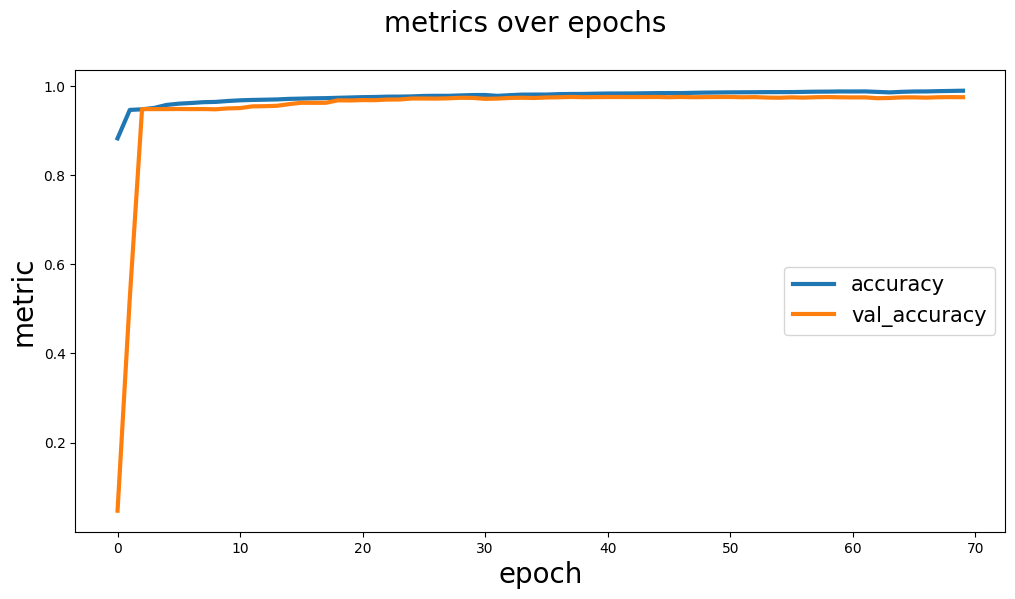

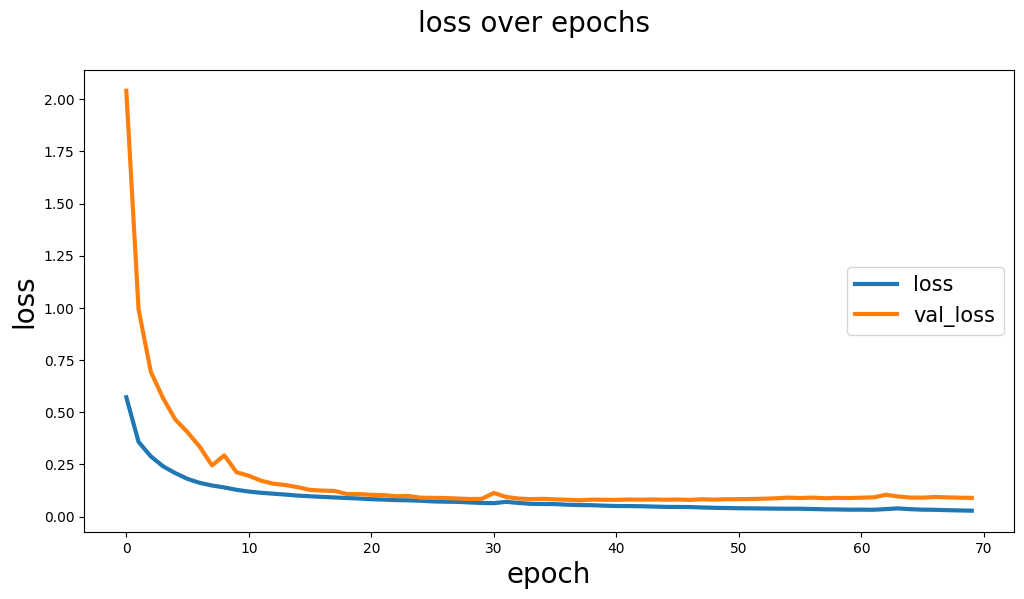

In [29]:

from keras_unet.utils import plot_segm_history
import matplotlib.pyplot as plt

# plot_segm_history code

# Plot the history
plot_segm_history(
    history,
    metrics=['accuracy', 'val_accuracy'],
    losses=['loss', 'val_loss']
)

plt.show()

1/1 [==============================] - 0s 22ms/step


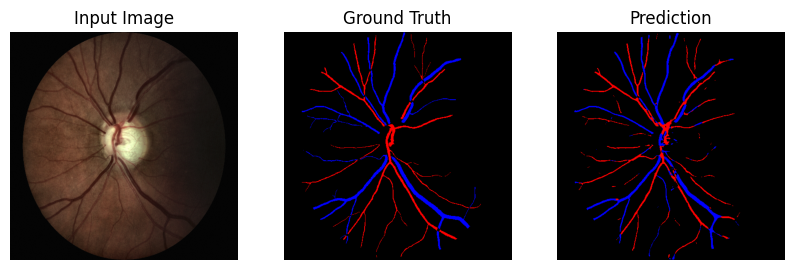

1/1 [==============================] - 0s 21ms/step


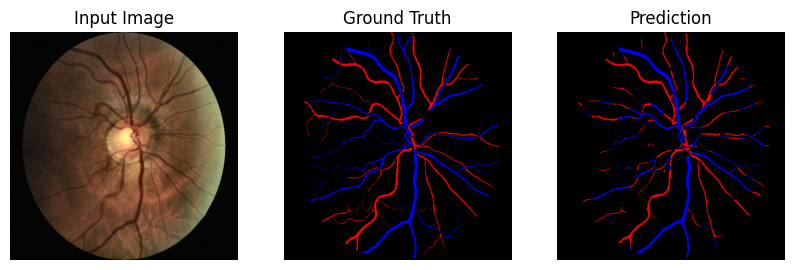

1/1 [==============================] - 0s 17ms/step


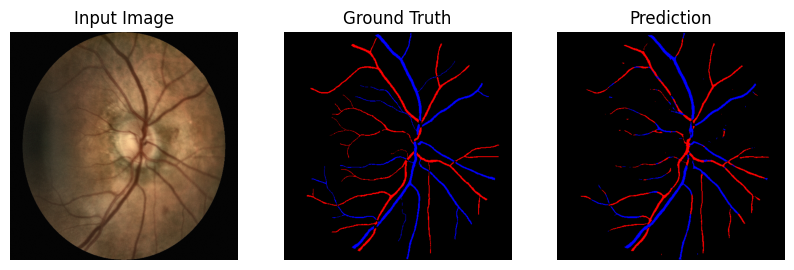

1/1 [==============================] - 0s 24ms/step


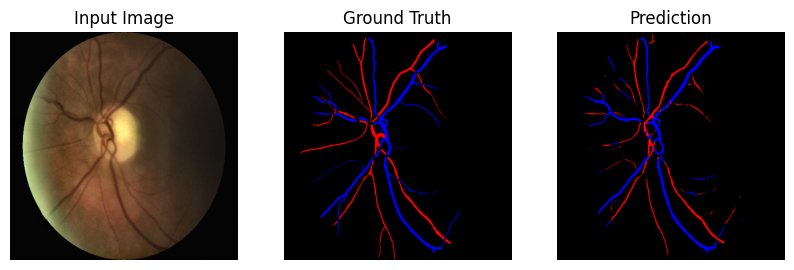

1/1 [==============================] - 0s 21ms/step


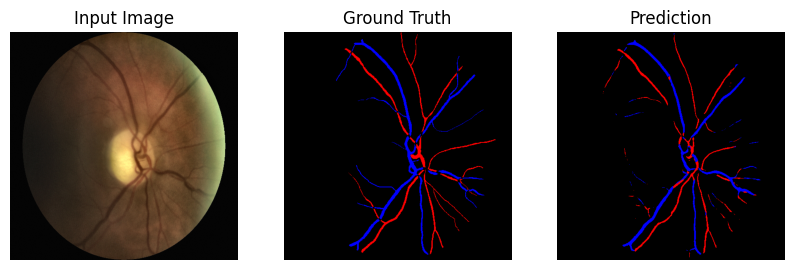

1/1 [==============================] - 0s 20ms/step


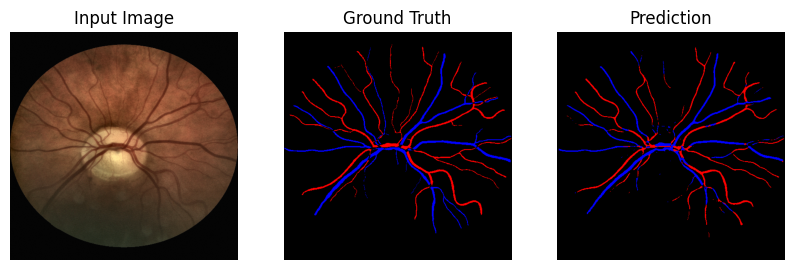

1/1 [==============================] - 0s 15ms/step


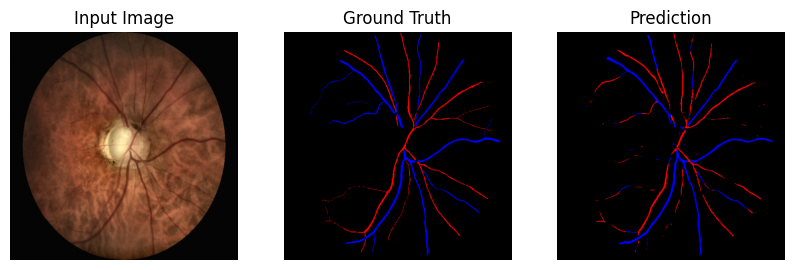

1/1 [==============================] - 0s 20ms/step


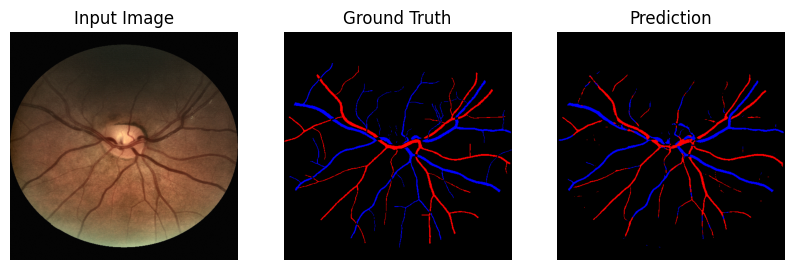

1/1 [==============================] - 0s 20ms/step


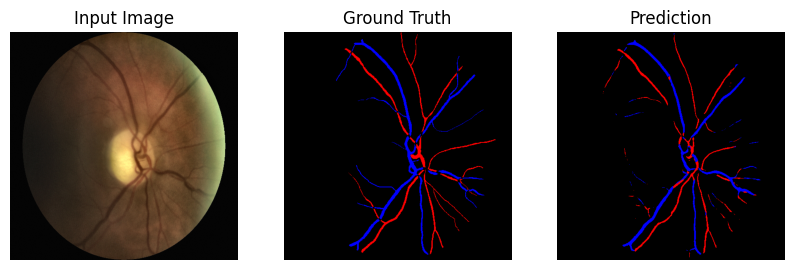

1/1 [==============================] - 0s 23ms/step


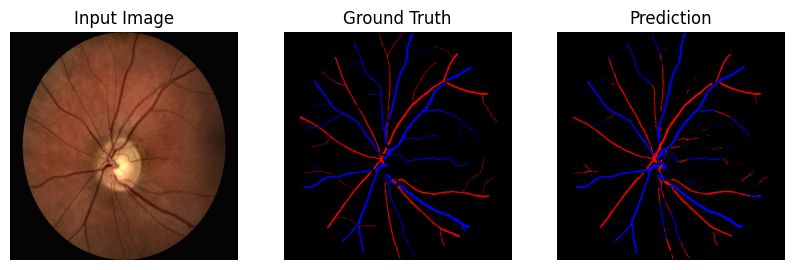

In [30]:
# Visualisasi model prediksi
for _ in range(10):
    # Pilih nomor acak dari 0 hingga ukuran set tes
    test_img_number = np.random.randint(0, len(X_test))

    # Ekstrak citra input tes
    test_img = X_test[test_img_number]

    # Membuat patch dari citra tes
    test_patches = create_patches(test_img, patch_size)

    # Mengambil hasil prediksi untuk setiap patch
    predictions = []
    for patch in test_patches:
        patch_input = np.expand_dims(patch, 0)
        prediction = model.predict(patch_input)
        predictions.append(np.squeeze(prediction))
    
    predictions = np.array(predictions)
    
    # Menggabungkan patch hasil prediksi menjadi gambar utuh
    reconstructed_prediction = recombine_patches(predictions, (512, 512, 3), patch_size)

    # Mengubah probabilitas softmax menjadi nilai integer
    predicted_img = np.argmax(reconstructed_prediction, axis=-1)

    # Mengubah encoding integer menjadi nilai RGB
    rgb_image = rgb_encode_mask(predicted_img)
    ground_truth = np.argmax(Y_test[test_img_number], axis=-1)
    rgb_ground_truth = rgb_encode_mask(ground_truth)

    # Visualisasi hasil prediksi model
    display_images(
        [test_img, rgb_ground_truth, rgb_image],
        rows=1, titles=['Input Image', 'Ground Truth', 'Prediction']
    )

In [31]:
# Load model
model_dir = 'D:/Gio&Maul/maul/LES-AV/'

model_name = 'aspp_unet_senet_LES-AV.hdf5'
model = tf.keras.models.load_model(model_dir + model_name, custom_objects={'iou_coef': iou_coef})

In [32]:
from sklearn.metrics import confusion_matrix, classification_report

In [33]:
# Membuat patch dari citra tes untuk prediksi
test_img_patches = []
for img in X_test:
    test_img_patches.extend(create_patches(img, patch_size))
test_img_patches = np.array(test_img_patches)

# Prediksi
predictions = model.predict(test_img_patches) 

# Rekonstruksi citra dari patch
reconstructed_preds = []
for i in range(len(X_test)):
    start_idx = i * (512 // patch_size) ** 2
    end_idx = (i + 1) * (512 // patch_size) ** 2
    reconstructed_pred = recombine_patches(predictions[start_idx:end_idx], (512, 512, 3), patch_size)
    reconstructed_preds.append(reconstructed_pred)

4/4 [==============================] - 2s 165ms/step


In [34]:
# Mengubah probabilitas softmax menjadi nilai integer
pred = [np.argmax(rp, axis=-1) for rp in reconstructed_preds]
pred = np.array(pred)

In [35]:
# Evaluasi menggunakan confusion matrix dan classification report
Y_test1 = np.argmax(Y_test, axis=3).flatten()
pred_flat = pred.flatten()
print("Confusion Matrix:")
print(confusion_matrix(Y_test1, pred_flat))

print("classification report:")
print(classification_report(Y_test1, pred_flat))



Confusion Matrix:
[[6596081   36377   28017]
 [  49016  129708   14025]
 [  45968   20135  158561]]
classification report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99   6660475
           1       0.70      0.67      0.68    192749
           2       0.79      0.71      0.75    224664

    accuracy                           0.97   7077888
   macro avg       0.82      0.79      0.81   7077888
weighted avg       0.97      0.97      0.97   7077888



In [36]:
# Rekonstruksi ground truth
reconstructed_ground_truths = []
for i in range(len(Y_test)):
    reconstructed_ground_truth = recombine_patches(create_patches(Y_test[i], patch_size), (512, 512, 3), patch_size)
    reconstructed_ground_truths.append(reconstructed_ground_truth)

reconstructed_ground_truths = np.array(reconstructed_ground_truths)


In [37]:
# Define class names based on your MaskColorMap
class_names = ['Background', 'Artery', 'Vein']

In [38]:
# Calculate metrics
metrics, cm = calculate_metrics_per_class(Y_test1, pred_flat, class_names)


In [39]:
# Print detailed results
print("\n=== Detailed Metrics per Class ===")
for metric_name, metric_values in metrics.items():
    print(f"\n{metric_name}:")
    for class_name, value in metric_values.items():
        print(f"{class_name}: {value:.4f}")


=== Detailed Metrics per Class ===

Sensitivity:
Background: 0.9903
Artery: 0.6729
Vein: 0.7058
Average: 0.7897

Specificity:
Background: 0.7724
Artery: 0.9918
Vein: 0.9939
Average: 0.9194

Accuracy:
Background: 0.9775
Artery: 0.9831
Vein: 0.9847
Average: 0.9818

IoU:
Background: 0.9764
Artery: 0.5204
Vein: 0.5945
Average: 0.6971

F1-Score:
Background: 0.9881
Artery: 0.6845
Vein: 0.7457
Average: 0.8061

Dice Coefficient:
Background: 0.9881
Artery: 0.6845
Vein: 0.7457
Average: 0.8061


In [40]:
# Print summary of average metrics
print("\n=== Summary of Average Metrics ===")
for metric_name, metric_values in metrics.items():
    print(f"Average {metric_name}: {metric_values['Average']:.4f}")


=== Summary of Average Metrics ===
Average Sensitivity: 0.7897
Average Specificity: 0.9194
Average Accuracy: 0.9818
Average IoU: 0.6971
Average F1-Score: 0.8061
Average Dice Coefficient: 0.8061


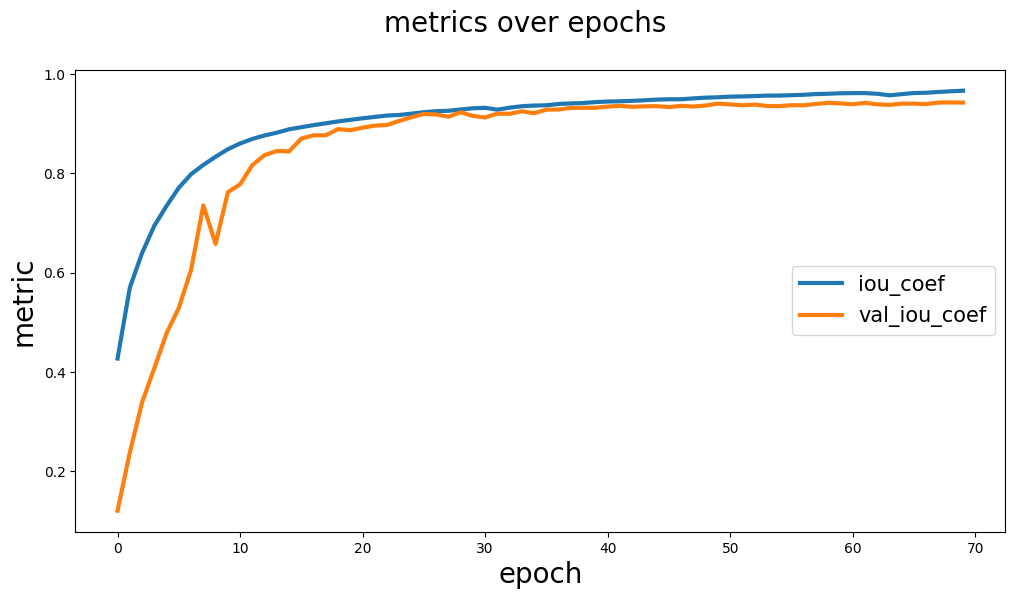

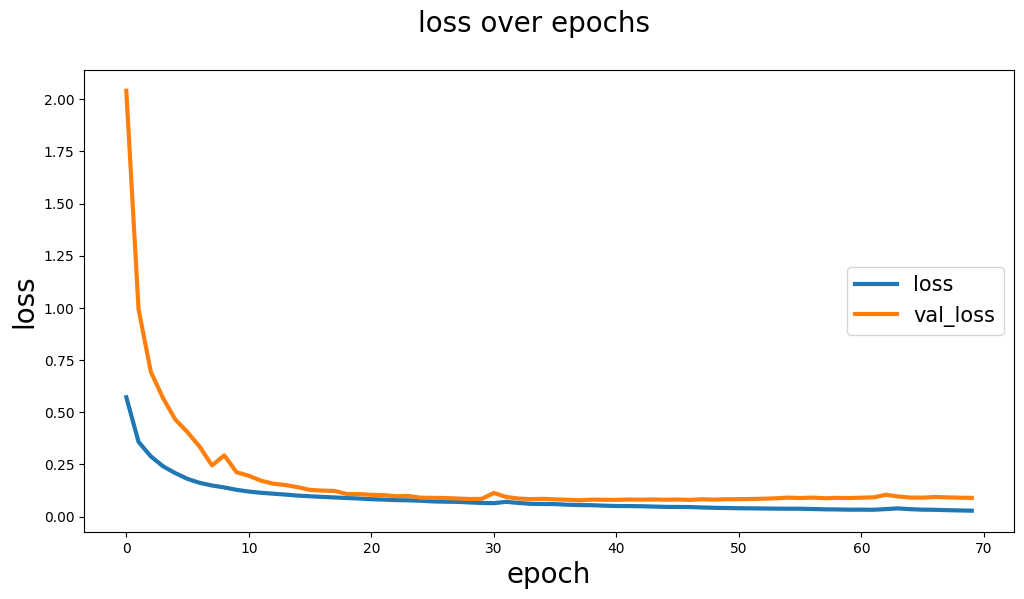

In [41]:
from keras_unet.utils import plot_segm_history
import matplotlib.pyplot as plt

# plot_segm_history code

# Plot the history
plot_segm_history(
    history,
    metrics=['iou_coef', 'val_iou_coef']
)
